In [1]:

import DW_oscillator as DW
import numpy as np
from IPython.display import clear_output

from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
def DW_EoM(t, y, params):
    """
    DW oscillator equation of motion

    Parameters
    ----------
    t  :  time
    y  :  array containing the DW position and angle
    params  :  DW class object containing all the parameter functions

    Returns
    ----------
    gradient : array of equation of motion
    """
    x, phi = y
    Bx, Bphi = params.fields(x, phi, t)
    dx = params.DW_width(phi)*params.beta*(params.alpha * Bx - Bphi)
    dphi = params.beta*(params.alpha*Bphi + Bx)
    return [dx, dphi]


In [3]:
class field_sequence:
    """
    callable class to produce a time dependent field sequence
    """
    def __init__ (self, fields, periods):
        import numpy as np

        self.fields = fields
        self.periods = periods
        self.periods_sum = np.cumsum(periods)

    def __call__ (self, t):
        if t < 0.0:
            val = 0.0
        elif t >= self.periods_sum[-1]:
            val = 0.0
        else:
            t_diff = self.periods_sum - t 
            n = 0
            for i in range(len(t_diff)):
                if t_diff[i] >= 0.0:
                    n = i 
                    break
            val = self.fields[n]
        return val

In [4]:
def run_field_sequence(field_low = 0.0, field_high = 1000.0, N_fields = 10, T = 4, dt = 0.1, y0 = [0.0, 0.0]):
    from scipy.integrate import solve_ivp
    rng = np.random.default_rng()
    fields = rng.uniform(field_low, field_high, N_fields)
    periods = np.ones(len(fields))*T
    total_time = np.sum(periods)
    print(fields)
    
    print(periods)

    htime = field_sequence(fields, periods)

    dw1 = DW(477e3, 1.05e-11, 0.02, (600e-9, 50e-9, 5e-9), -1.28e-6, 1.63e8, 0.0, 0.5, htime)

    t_eval = np.arange(0, total_time, dt)
    sol = solve_ivp( DW_EoM, [0, total_time], y0, args=[dw1], t_eval=t_eval)

    h_vals = np.zeros_like(sol.t)
    for i in range(len(h_vals)):
        h_vals[i] = dw1.Happ(t_eval[i])

    return sol.t, sol.y, h_vals, fields, periods


"run_field_sequence" that randomly generates and simulates a set of fields. It returns the time, DW position and angle plus the input time sequence.
field_low and field_high specify the range the fields will be generated over while N_fields is the number of fields in the sequence and T is the time period of each field.

The outputs of interest are t, y and h_t. y[0] is the DW position over time (at time points given in t) and h_t is the magnetic field (serves as input) at the same times.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [62]:
t, y, h_t, fields, periods = DW.run_field_sequence(field_low = 100, field_high = 100.0, N_fields = 1, T = 40,y0 = [60.0,0.0])

[100.]
[40.]


In [63]:
t.shape,y.shape,h_t.shape,fields.shape,periods.shape

((400,), (2, 400), (400,), (1,), (1,))

In [64]:
fields,periods

(array([100.]), array([40.]))

In [65]:
class DWODE(nn.Module):
    """
    neural network for learning the chaotic lorenz system
    """
    def __init__(self):
        super(DWODE, self).__init__()
        self.lin = nn.Linear(3, 64)
        self.lin2 = nn.Linear(64, 128)
        self.lin3 = nn.Linear(128,256)
        self.lin4 = nn.Linear(256,3)
        self.tanh = nn.Tanh()
        

    def forward(self, t,x):
        x = self.tanh(self.lin(x))
        x = self.tanh(self.lin2(x))
        x = self.tanh(self.lin3(x))
        x = self.lin4(x)
        return x
     

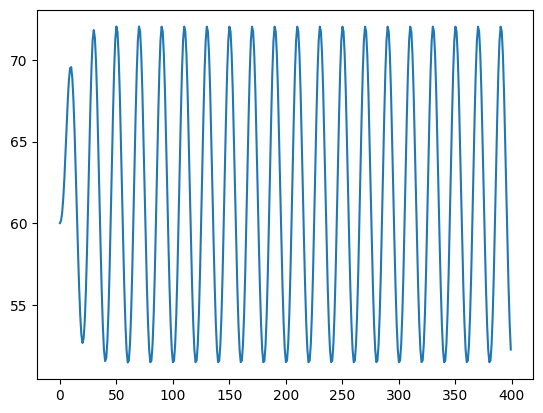

In [66]:
plt.plot(y[0])

In [67]:
y.shape

(2, 400)

In [68]:
time = torch.tensor(t).to(device)

In [69]:
h_t_ = torch.tensor(h_t, dtype=torch.float64)  # Converting to column vector
y_0_ = torch.tensor(y[0], dtype=torch.float64)  # Converting to column vector
y_1_ = torch.tensor(y[1], dtype=torch.float64)  # Converting to column vector

# Stack the tensors horizontally
train = torch.stack((h_t_,y_0_, y_1_)).to(device)

In [70]:
train.shape

torch.Size([3, 400])

In [71]:
train = train.transpose(0,1)

In [72]:
train.shape

torch.Size([400, 3])

In [119]:
model = DWODE().double().to(device)

In [120]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [75]:
def get_batch(true_y, batch_size):
    num_samples = len(true_y)
    indices = np.random.choice(np.arange(num_samples - batch_size, dtype=np.int64), size=batch_size, replace=False)
    indices.sort()
    #print(indices)
    batch_y0 = true_y[indices]  # (batch_size, D)
    batch_t = time[:batch_size]  # (batch_size)
    batch_y = torch.stack([true_y[indices + i] for i in range(batch_size)], dim=0)  # (batch_size, M, D)
    return batch_y0,batch_t,batch_y

In [76]:
from torchdiffeq import odeint_adjoint as adjoint

Iter 0900 | Total Loss 1763.318692


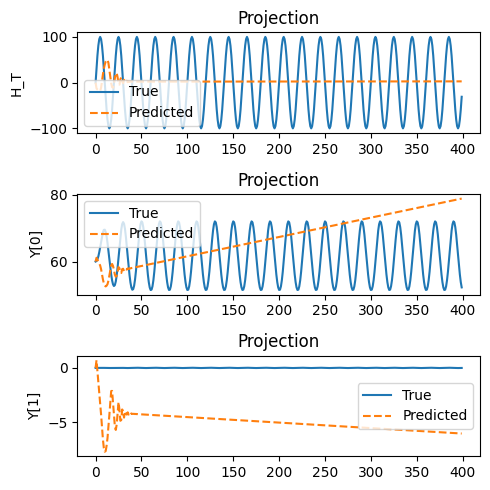

In [121]:
for i in range(1000):
   
    optimizer.zero_grad()
    
    init,batch_t,truth = get_batch(train,8)
    #print(init,batch_t,truth)
    pred_y = adjoint(model,init,batch_t,method='dopri5')
    loss = F.mse_loss(pred_y, truth)
    loss.backward()
    
    optimizer.step()
   
    
    if i % 100 == 0:
        with torch.no_grad():
            pred_y = adjoint(model, train[0], time,method='dopri5')
            loss = F.mse_loss(pred_y, train)
            print('Iter {:04d} | Total Loss {:.6f}'.format(i, loss.item()))
            x_pred = pred_y[:,0].cpu()
            y_pred = pred_y[:,1].cpu()
            z_pred = pred_y[:,2].cpu()

            # Extract the x, y, z coordinates from X_train_plt
            x_train = train[:,0].cpu()
            y_train = train[:,1].cpu()
            z_train = train[:,2].cpu()

            fig, ax = plt.subplots(3, 1, figsize=(5, 5))
            ax[0].plot(x_train, label='True')
            ax[0].plot(x_pred, label='Predicted', linestyle='--')
            ax[0].set_ylabel('H_T')
            ax[0].set_title('Projection')
            ax[0].legend()

            ax[1].plot(y_train, label='True')
            ax[1].plot(y_pred, label='Predicted',linestyle='--')
            ax[1].set_ylabel('Y[0]')
            ax[1].set_title('Projection')
            ax[1].legend()

            ax[2].plot(z_train, label='True')
            ax[2].plot(z_pred, label='Predicted',linestyle='--')
            ax[2].set_ylabel('Y[1]')
            
            ax[2].set_title('Projection')
            ax[2].legend()

            plt.tight_layout()
            plt.show()
            clear_output(wait=True)

In [122]:
with torch.no_grad():
    pred = odeint(model, train[0], time)
  

In [123]:
pred = pred.cpu().detach().numpy()

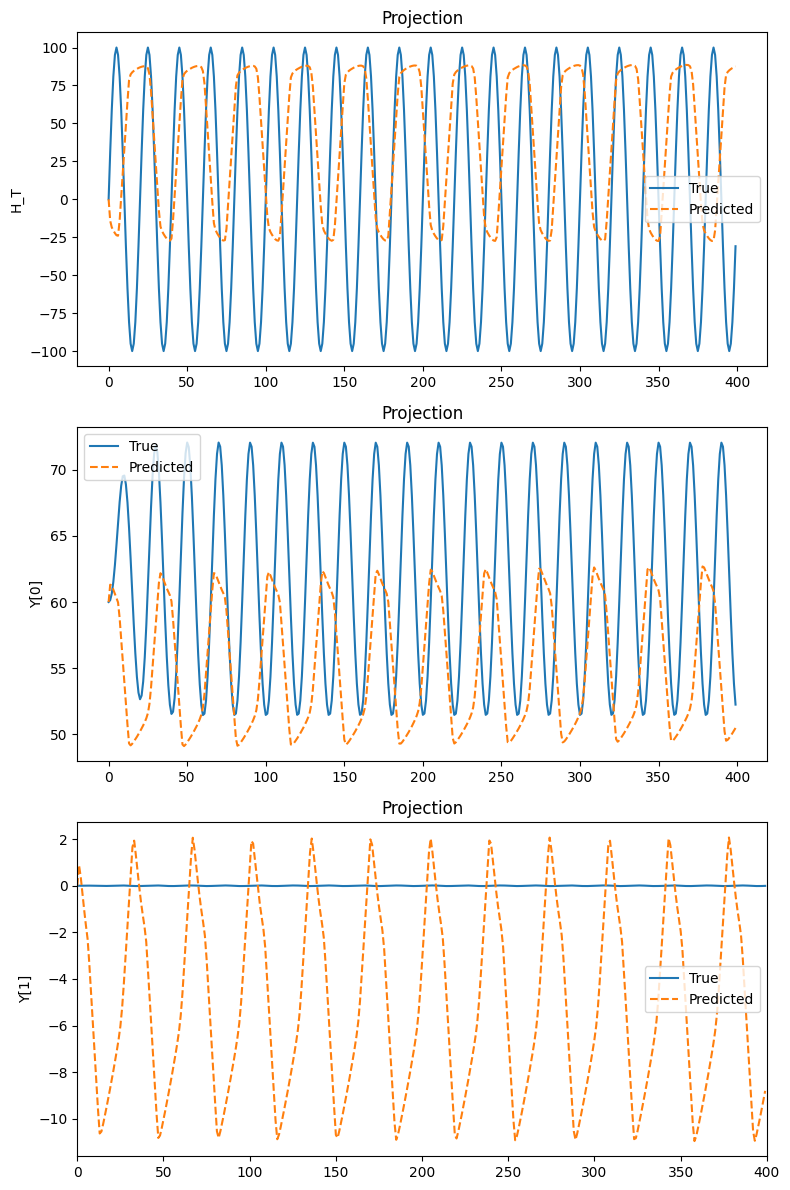

In [125]:
# Extract the x, y, z coordinates from predictions_plt
x_pred = pred[:,0]
y_pred = pred[:,1]
z_pred = pred[:,2]

# Extract the x, y, z coordinates from X_train_plt
x_train = train[:,0].cpu()
y_train = train[:,1].cpu()
z_train = train[:,2].cpu()

fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(x_train, label='True')
ax[0].plot(x_pred, label='Predicted',linestyle='--')
ax[0].set_ylabel('H_T')
# ax[0].set_xlim(0, 200)
# ax[0].set_ylim(0, 300)
ax[0].set_title('Projection')
ax[0].legend()

ax[1].plot(y_train, label='True')
ax[1].plot(y_pred, label='Predicted',linestyle='--')
ax[1].set_ylabel('Y[0]')
ax[1].set_title('Projection')
ax[1].legend()

ax[2].plot(z_train, label='True')
ax[2].plot(z_pred, label='Predicted',linestyle='--')
ax[2].set_ylabel('Y[1]')
ax[2].set_xlim(0, 400)
ax[2].set_title('Projection')
ax[2].legend()
#plt.savefig('projection.png')
plt.tight_layout()
plt.show()